In [55]:
import torch, numpy, os
from os import getcwd
from preprocess import data_preprocess, train_model
from selection import generate_labels, save, TechnicalIndicator
import pandas as pd

In [56]:
os.chdir('/users/abhijitdeshpande/desktop/indicators')

In [57]:
file = [x.split('.')[0] for x in os.listdir()]

In [58]:
file[:10]

['CSCO', 'UAL', 'BA', 'V', 'EIX', 'WBA', '', 'PEG', 'R', 'JBLU']

In [59]:
name = file[23]

In [60]:
name = name
data = pd.read_csv('/Users/abhijitdeshpande/Downloads/DJI65_2Y60min/'+name+'_2Y60min.csv')
data = TechnicalIndicator()(data)
labels = generate_labels(data,20,2,0.5)
labels = labels.get_labels()
labels.out = labels.out.apply(lambda x:1 if x>0.5 else 0 )
save(labels,name)

In [61]:
name

'MSFT'

In [62]:
preprocess = data_preprocess()

In [63]:
path = '/Users/abhijitdeshpande/Documents/Project Files/Full Hourly Data/'

In [64]:
preprocess.get_data(name=name, path=path,days=15,test_size=0.3)

In [65]:
train, val, test, feat_dim, max_len  = preprocess.prepare_data()

Total Samples: 7669
Training Samples: 5368
Validation Samples: 1150
Testing Samples: 1151


In [66]:
from modules import TSTransformerEncoderLSTM, TSTransformerEncoderClass

In [67]:
import torch.nn as nn
import numpy as np

In [116]:
torch.manual_seed(10)
super_model = TSTransformerEncoderLSTM(feat_dim,max_len,128,16,3,
                                             128, 2,lstm_layers=3, hidden_layers=64,dropout=0.5)

In [117]:
supervised = train_model(super_model)
supervised.compile(loss = nn.CrossEntropyLoss(),optimizer=torch.optim.Adam,lr=1e-5)

Epoch: 0 57.06% loss: 0.6892  Val: 56.342 val_loss: 0.6973
Epoch: 1 57.201% loss: 0.688  Val: 56.603 val_loss: 0.6961
Epoch: 2 57.616% loss: 0.6867  Val: 56.342 val_loss: 0.695
Epoch: 3 58.485% loss: 0.6846  Val: 56.082 val_loss: 0.6942
Epoch: 4 58.307% loss: 0.6836  Val: 55.995 val_loss: 0.6933
Epoch: 5 59.088% loss: 0.6816  Val: 56.513 val_loss: 0.6924
Epoch: 6 59.404% loss: 0.6811  Val: 56.166 val_loss: 0.6913
Epoch: 7 59.646% loss: 0.6794  Val: 56.426 val_loss: 0.6904
Epoch: 8 59.596% loss: 0.6789  Val: 56.426 val_loss: 0.6894
Epoch: 9 59.928% loss: 0.6773  Val: 56.687 val_loss: 0.6883
Epoch: 10 59.76% loss: 0.6761  Val: 57.121 val_loss: 0.6875
Epoch: 11 59.837% loss: 0.6751  Val: 57.642 val_loss: 0.6865
Epoch: 12 59.776% loss: 0.6748  Val: 57.815 val_loss: 0.6857
Epoch: 13 59.989% loss: 0.6739  Val: 58.597 val_loss: 0.685
Epoch: 14 60.116% loss: 0.6727  Val: 59.551 val_loss: 0.6845
Epoch: 15 60.175% loss: 0.672  Val: 59.812 val_loss: 0.6839
Epoch: 16 59.909% loss: 0.6704  Val: 59.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


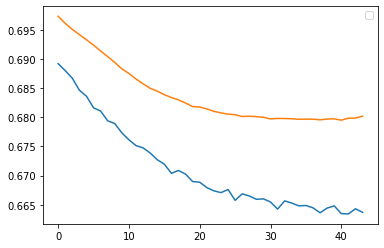

In [118]:
supervised.train(train, val, verbose=True, return_loss=True, epochs=300 , batch_size=64)


Accuracy:  0.5499565595134666

Classification Report:

              precision    recall  f1-score   support

           0       0.10      0.29      0.15       156
           1       0.84      0.59      0.69       995

    accuracy                           0.55      1151
   macro avg       0.47      0.44      0.42      1151
weighted avg       0.74      0.55      0.62      1151


Confusion Matrix:

            Total Data Samples: 1151 

            Class 0: 454
            Class 1: 697 

Confusion matrix, without normalization
[[ 46 110]
 [408 587]]




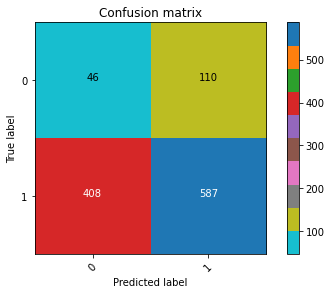

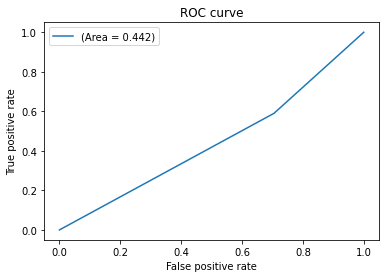

In [119]:
supervised.analyze(test, color='tab10_r')

In [32]:
best_loss

array(0.67132807, dtype=float32)

In [13]:
import optuna

In [22]:
def _train(params, train, val):
    torch.manual_seed(10)
    super_model = TSTransformerEncoderLSTM(feat_dim,max_len,64,16,1,
                                         params['dim_feedforward'],2,params['lstm_layers'],
                                         params['hidden_layers'],params['dropout'])
    supervised = train_model(super_model)
    supervised.compile(params['lr'],loss = nn.CrossEntropyLoss(),optimizer=torch.optim.Adam)
    best_loss = supervised.train(train, val, verbose=False, return_loss=False, epochs=3000, 
                                 batch_size=256,metric=True)
    return best_loss

In [ ]:
def objective(trial):
    params = {
        #'d_model':trial.suggest_int('d_model',4,256),
        'dim_feedforward':trial.suggest_int('dim_feedforward',4,256),
        'lstm_layers':trial.suggest_int('lstm_layers',1,3),
        'hidden_layers':trial.suggest_int('hidden_layers',16,256),
        'lr':trial.suggest_loguniform('lr',1e-7,1e-3),
        'dropout':trial.suggest_uniform('dropout',0.1,0.7)
    }
    
    _best_loss = _train(params,train,val).item()
    
    return _best_loss  

In [25]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=4)
print('best trail:')
trial_ = study.best_trial
print(trial_.values)
print(trial_.best_params)

[I 2021-12-20 01:11:11,101] A new study created in memory with name: no-name-d920db90-46ad-43e5-9a18-8fb80f739d26
[I 2021-12-20 01:39:02,742] Trial 0 finished with value: 0.6627538204193115 and parameters: {'dim_feedforward': 20, 'lstm_layers': 2, 'hidden_layers': 110, 'lr': 6.472607070689779e-05, 'dropout': 0.6600224915163333}. Best is trial 0 with value: 0.6627538204193115.
[I 2021-12-20 03:02:40,566] Trial 1 finished with value: 0.6993124485015869 and parameters: {'dim_feedforward': 255, 'lstm_layers': 3, 'hidden_layers': 52, 'lr': 0.0005566764955475923, 'dropout': 0.6306533967032634}. Best is trial 0 with value: 0.6627538204193115.
[I 2021-12-20 12:03:03,944] Trial 2 finished with value: 0.6717376112937927 and parameters: {'dim_feedforward': 209, 'lstm_layers': 3, 'hidden_layers': 129, 'lr': 7.603282875946739e-06, 'dropout': 0.3970119608315369}. Best is trial 0 with value: 0.6627538204193115.
[I 2021-12-20 14:38:49,854] Trial 3 finished with value: 0.6893141865730286 and parameters

best trail:
[0.6627538204193115]


AttributeError: 'FrozenTrial' object has no attribute 'best_params'

In [54]:
trial_

FrozenTrial(number=0, values=[0.6627538204193115], datetime_start=datetime.datetime(2021, 12, 20, 1, 11, 11, 105163), datetime_complete=datetime.datetime(2021, 12, 20, 1, 39, 2, 742090), params={'dim_feedforward': 20, 'lstm_layers': 2, 'hidden_layers': 110, 'lr': 6.472607070689779e-05, 'dropout': 0.6600224915163333}, distributions={'dim_feedforward': IntUniformDistribution(high=256, low=4, step=1), 'lstm_layers': IntUniformDistribution(high=3, low=1, step=1), 'hidden_layers': IntUniformDistribution(high=256, low=16, step=1), 'lr': LogUniformDistribution(high=0.001, low=1e-07), 'dropout': UniformDistribution(high=0.7, low=0.1)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=0, state=TrialState.COMPLETE, value=None)

In [22]:
name

'D'

In [23]:
path = '/Users/abhijitdeshpande/Desktop/Models/'+name

In [24]:
torch.save(super_model,path)

In [52]:
import numpy as np
import torch
import torch.nn as nn

In [53]:
class identity_block(nn.Module):
    def __init__(self,ni,nf,f=3):
        super(identity_block,self).__init__()
        
        self.conv1 = nn.Conv1d(ni, nf, kernel_size=1, stride=1,padding='valid')
        self.conv2 = nn.Conv1d(nf, nf, kernel_size=f,stride=1,padding='same')
        self.conv3 = nn.Conv1d(nf, nf, kernel_size=1,stride=1,padding='valid')
        
        self.batchnorm = nn.BatchNorm1d(nf)
        self.act = nn.ReLU()
        self.add = torch.add
        
    def forward(self,x):
    
        x_shortcut = x
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.act(x)
        
        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.act(x)
        
        x = self.conv3(x)
        x = self.batchnorm(x)
        
        x = self.add(x_shortcut,x)
        x = self.act(x)
        
        return x

In [54]:
class convolution_block(nn.Module):
    def __init__(self, ni, nf, f, s=2):
        super(convolution_block,self).__init__()
        
        
        self.conv1 = nn.Conv1d(ni, nf, kernel_size=1, stride=s,padding='valid')
        self.conv2 = nn.Conv1d(nf, nf, kernel_size=f,stride=1,padding='same')
        self.conv3 = nn.Conv1d(nf, nf, kernel_size=1,stride=1,padding='valid')

        # expand channels for the sum if necessary
        self.shortcut = nn.Conv1d(ni, nf, 1, stride=s,padding='valid')
        self.batchnorm = nn.BatchNorm1d(nf)
        self.add = torch.add
        self.act = nn.ReLU()

    def forward(self, x):
        
        x_shortcut = x
        x = self.conv1(x)
        x = self.batchnorm(x)
        x = self.act(x)
        
        x = self.conv2(x)
        x = self.batchnorm(x)
        x = self.act(x)
        
        x = self.conv3(x)
        x = self.batchnorm(x)
        x = self.act(x)
        
        x_shortcut = self.shortcut(x_shortcut)
        x_shortcut = self.batchnorm(x_shortcut)
        
        x = self.add(x, x_shortcut)
        x = self.act(x)
        
        return x

In [55]:
class ResNet(nn.Module):
    def __init__(self, c_in, c_out):
        super(ResNet,self).__init__()
        nf = 64
        self.conv1 = convolution_block(c_in, nf, f=3,s=1)
        self.conv2 = convolution_block(nf, nf * 2, f=3)
        self.conv3 = convolution_block(nf * 2, nf * 4, f=3)
        self.conv4 = convolution_block(nf*4, nf*8, f=3)
        self.identity1 = identity_block(nf,nf)
        self.identity2 = identity_block(nf*2,nf*2)
        self.identity3 = identity_block(nf*4, nf*4)
        self.identity4 = identity_block(nf*8, nf*8)
        self.gap = nn.AdaptiveAvgPool1d(1)
        self.squeeze = nn.Flatten()
        self.fc = nn.Linear(nf * 8, c_out)

    def forward(self, x, mask=None):
        x = self.conv1(x)
        x = self.identity1(x)
        x = self.conv2(x)
        x = self.identity2(x)
        x = self.conv3(x)
        x = self.identity3(x)
        x = self.conv4(x)
        x = self.identity4(x)
        x = self.squeeze(self.gap(x))
        return self.fc(x)

In [63]:
resnet = ResNet(max_len,2)

In [64]:
model = train_model(resnet)
model.compile(lr=0.0000001)

Epoch: 0 60.267% loss: 0.7309  Val: 61.986 val_loss: 1.7298
Epoch: 1 60.267% loss: 0.73  Val: 61.986 val_loss: 2.1416
Epoch: 2 60.267% loss: 0.7292  Val: 61.986 val_loss: 2.1469
Epoch: 3 60.267% loss: 0.7284  Val: 61.986 val_loss: 2.1449
Epoch: 4 60.267% loss: 0.7277  Val: 61.986 val_loss: 2.1428
Epoch: 5 60.267% loss: 0.7269  Val: 61.986 val_loss: 2.1407
Epoch: 6 60.267% loss: 0.7261  Val: 61.986 val_loss: 2.1386
Epoch: 7 60.267% loss: 0.7254  Val: 61.986 val_loss: 2.1367
Epoch: 8 60.267% loss: 0.7246  Val: 61.986 val_loss: 2.1347
Epoch: 9 60.267% loss: 0.7239  Val: 61.986 val_loss: 2.1328
Epoch: 10 60.267% loss: 0.7231  Val: 61.986 val_loss: 2.131


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


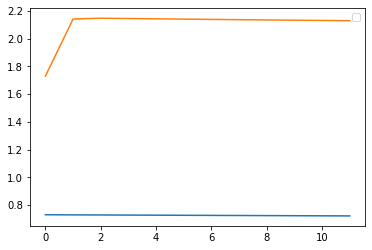

In [65]:
model.train(train, val, batch_size=256,epochs=100,return_loss=True)


Accuracy:  0.613603473227207

Classification Report:

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.61      0.76       691

    accuracy                           0.61       691
   macro avg       0.50      0.31      0.38       691
weighted avg       1.00      0.61      0.76       691


Confusion Matrix:

            Total Data Samples: 691 

            Class 0: 267
            Class 1: 424 

Confusion matrix, without normalization
[[  0   0]
 [267 424]]


Something wrong


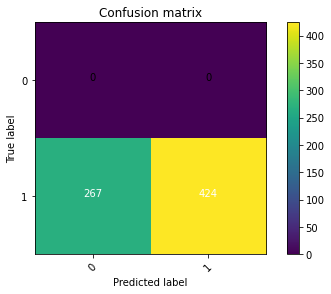

In [66]:
model.analyze(val)

In [69]:
import optuna

In [70]:
TSTransformerEncoderLSTM()

TypeError: __init__() missing 7 required positional arguments: 'feat_dim', 'max_len', 'd_model', 'n_heads', 'num_layers', 'dim_feedforward', and 'num_classes'